In [24]:
import pandas as pd
import numpy as np
import sklearn
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay

### Data cleanen en opsplitsen in training en test set

In [25]:
df = pd.read_csv('../data/weblogs.csv')

df = df.drop(['NIGHT', 'ID', 'OTHER_METHOD'], axis=1)

X = df.loc[:, df.columns != 'ROBOT']
y = df['ROBOT']

X = X.fillna(0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### BaggingClassifier met DecisionTreeClassifier - zonder OOB

- n_estimators = 500 --> 500 decision trees getrained op subset vd data
- max_samples = 100 --> elke tree zal op 100 samples v/e random subset worden getrained
- bootstrap = True --> training data samples zullen replaced worden

In [26]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

#### Accuracy

In [27]:
print(accuracy_score(y_test, y_pred))

0.9490015589043129


### BaggingClassifier met DecisionTreeClassifier - met OOB

- oob_score = True --> niet gebruikte data samples voor evaluatie BaggingClassifier

#### oob score

In [28]:
bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, oob_score=True, n_jobs=-1, random_state=42)

bag_clf.fit(X_train, y_train)

bag_clf.oob_score_

0.9513186466472412

In [29]:
bag_clf.oob_decision_function_[:3]

array([[0.99396378, 0.00603622],
       [0.96385542, 0.03614458],
       [0.93587174, 0.06412826]])

#### accuracy

- zeer dicht bij oob_score_

In [30]:
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9490015589043129

#### Precision, recall en f1-score

In [31]:
# precision, recall and f1 score
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10785
           1       0.84      0.92      0.88      2686

    accuracy                           0.95     13471
   macro avg       0.91      0.94      0.92     13471
weighted avg       0.95      0.95      0.95     13471



### Feature importance

In [32]:
features = X.columns

dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

importances = dt_clf.feature_importances_

df_importances = pd.DataFrame({'feature': features, 'importance': importances})
df_importances = df_importances.sort_values(by='importance', ascending=False)
df_importances

,feature,importance
12,UNASSIGNED,0.689933
22,DATA,0.102764
23,PPI,0.038023
27,PENALTY,0.035138
17,HTML_TO_JS,0.025373
5,HTTP_RESPONSE_2XX,0.021188
19,DEPTH,0.016657
14,TOTAL_HTML,0.014064
2,AVERAGE_TIME,0.011097
1,TOTAL_DURATION,0.010143


<Axes: xlabel='feature'>

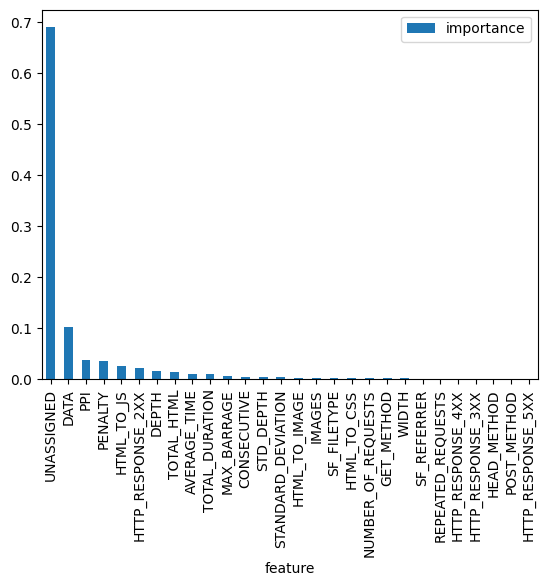

In [33]:
df_importances.plot.bar(x='feature', y='importance')

### GridsearchCV

In [34]:
param_grid = {
    'max_depth': np.arange(9, 25),
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2, 4],
}

grid_search = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

{'max_depth': 14, 'min_samples_leaf': 1, 'min_samples_split': 4}

In [35]:
grid_search.best_score_

0.9752973970729686

In [36]:
dt_clf = grid_search.best_estimator_

y_pred = dt_clf.predict(X_test)

print(accuracy_score(y_test, y_pred))

print(classification_report(y_test, y_pred))

0.9751317645312152
              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10785
           1       0.93      0.94      0.94      2686

    accuracy                           0.98     13471
   macro avg       0.96      0.96      0.96     13471
weighted avg       0.98      0.98      0.98     13471



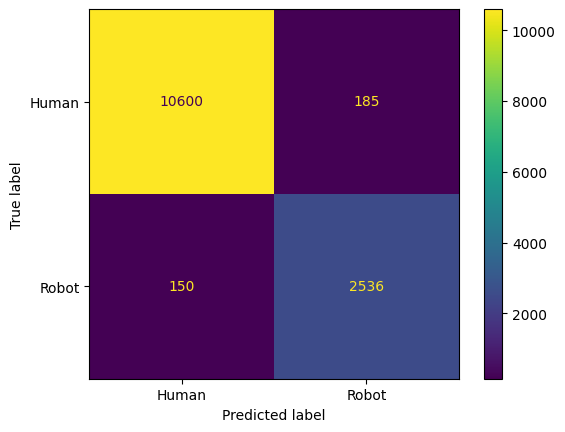

In [37]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [ ]:
filename = '../models/dec_tree.sav'
pickle.dump(dt_clf, open(filename, 'wb'))

### Ada boost

In [38]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

y_pred = ada_clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred)}\n")

print(classification_report(y_test, y_pred))

0.9555341103110385

              precision    recall  f1-score   support

           0       0.98      0.96      0.97     10785
           1       0.86      0.92      0.89      2686

    accuracy                           0.96     13471
   macro avg       0.92      0.94      0.93     13471
weighted avg       0.96      0.96      0.96     13471



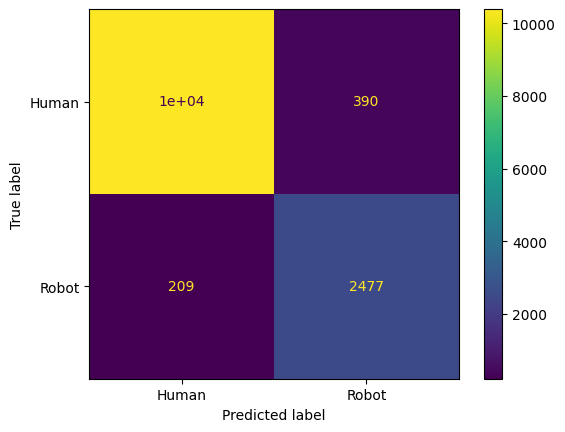

In [39]:
cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [44]:
filename = '../models/ada_clf.sav'
pickle.dump(ada_clf, open(filename, 'wb'))

### Gradient boost

In [41]:
gbrt = GradientBoostingClassifier(max_depth=10, n_estimators=120, learning_rate=0.1, random_state=42)
gbrt.fit(X_train, y_train)

errors_gbrt = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]

best_n_estimators = np.argmin(errors_gbrt) + 1

gbrt_best = GradientBoostingClassifier(max_depth=10, n_estimators=best_n_estimators, learning_rate=0.1, random_state=42)
gbrt_best.fit(X_train, y_train)

y_pred = gbrt_best.predict(X_test)

print(f"{accuracy_score(y_test, y_pred)}\n")

print(classification_report(y_test, y_pred))

0.9792146091604187

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10785
           1       0.95      0.95      0.95      2686

    accuracy                           0.98     13471
   macro avg       0.97      0.97      0.97     13471
weighted avg       0.98      0.98      0.98     13471



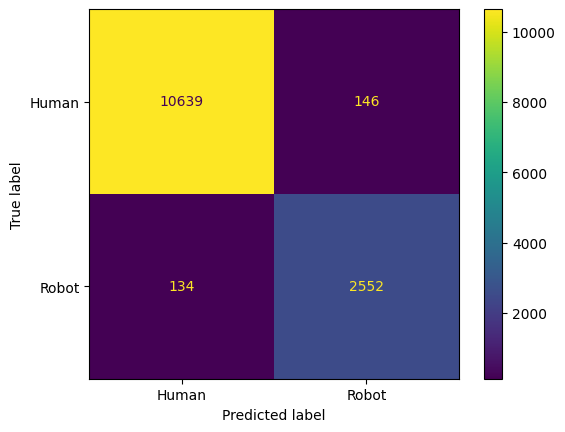

In [42]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [43]:
filename = '../models/grad_boost.sav'
pickle.dump(gbrt_best, open(filename, 'wb'))